This is a notebook that calculates neutron capture cross sections at a given T9 in units of millibarns $(mb)$

Here we import the relavent python packages

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnutils

!{sys.executable} -m pip install --quiet astropy

!{sys.executable} -m pip install --quiet networkx

import os, io, requests
from lxml import etree

import wnutils.xml as wx
import numpy as np
from astropy import constants as pc
from astropy import units as u
from matplotlib import pyplot as plt

from collections import defaultdict

import networkx as nx

Retrieve network data from [OSF](https://osf.io/5cyg7/) or use a local file.  To use a local file, upload the network XML file to the local directory and execute the relevant command.  In the commented case, the file would be *example.xml*, so you would upload that file and uncomment the read line.

In [2]:
my_xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
#my_xml = wx.Xml('example.xml')

Use an xpath expression to select out only $(n, \gamma)$ reaction data.

In [3]:
reac = my_xml.get_reaction_data("[reactant = 'n' and count(reactant) = 2  and product = 'gamma' and count(product) = 2]")

Select a set of nuclides with an XPath expression.

In [4]:
nuc_xpath = "[z = 40 and a >= 90 and a <= 100]"

nuclides = my_xml.get_nuclide_data(nuc_xpath)

Now choose the temperature, T9, to calculate the cross sections.  Convert T9 to T in K.

In [5]:
T9 = 0.8
T = T9 * 1.e9 * u.K

Now calculate the thermal velocity.

In [6]:
v_t = np.sqrt((2 * pc.k_B.decompose(u.cgs.bases) * T) / pc.m_n.decompose(u.cgs.bases))

In [7]:
sig_dict = {}

for s in reac:
    reaction = reac[s]
    rate = reaction.compute_rate(T9) * u.cm**3 /u.second /u.mol 
    sigma = (rate / (pc.N_A * v_t)).to(u.barn)
        
    usigma = 1000 * sigma / u.barn
    sig_dict[s] = usigma 

We now specify that we only want the $(n,\gamma)$ reactions with the nuclides of interest

In [8]:
filter = {}

for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            filter[reaction] = [nuclides[reactant]['n']]
            
for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            filter[reaction].append(reactant)
            
print(filter)

{'n + zr98 -> zr99 + gamma': [58, 'zr98'], 'n + zr92 -> zr93 + gamma': [52, 'zr92'], 'n + zr91 -> zr92 + gamma': [51, 'zr91'], 'n + zr97 -> zr98 + gamma': [57, 'zr97'], 'n + zr94 -> zr95 + gamma': [54, 'zr94'], 'n + zr100 -> zr101 + gamma': [60, 'zr100'], 'n + zr93 -> zr94 + gamma': [53, 'zr93'], 'n + zr95 -> zr96 + gamma': [55, 'zr95'], 'n + zr99 -> zr100 + gamma': [59, 'zr99'], 'n + zr96 -> zr97 + gamma': [56, 'zr96'], 'n + zr90 -> zr91 + gamma': [50, 'zr90']}


In [9]:
for key in list(sig_dict.keys()):
    if key not in filter:
        del sig_dict[key]

Change 2 in {.2f} to change the numver of decimal places shown

In [10]:
print('Cross Sections at T9 = ' + str(T9))
print()

for k,v in sorted(sig_dict.items()):
    x ="{:.2f}".format(v)
    print(str(k)+': ' + str(x) + ' mb')

Cross Sections at T9 = 0.8

n + zr100 -> zr101 + gamma: 5.68 mb
n + zr90 -> zr91 + gamma: 14.40 mb
n + zr91 -> zr92 + gamma: 35.25 mb
n + zr92 -> zr93 + gamma: 21.69 mb
n + zr93 -> zr94 + gamma: 49.04 mb
n + zr94 -> zr95 + gamma: 21.76 mb
n + zr95 -> zr96 + gamma: 43.43 mb
n + zr96 -> zr97 + gamma: 5.29 mb
n + zr97 -> zr98 + gamma: 8.93 mb
n + zr98 -> zr99 + gamma: 7.32 mb
n + zr99 -> zr100 + gamma: 18.92 mb


We now plot $\sigma_n$ vs $n$

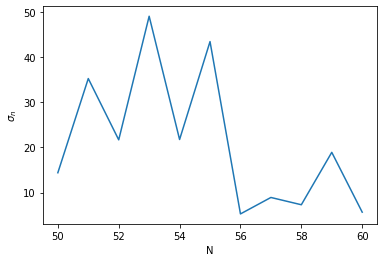

In [11]:
combine = defaultdict(list)

for d in (sig_dict, filter):
    for key, value in d.items():
       combine[key].append(value)
    
sortedcombine = {k: v for k, v in sorted(combine.items(), key=lambda item: item[1][1])}


x = []
y = []

for s in list(sortedcombine.values()):
    x.append(s[1][0])
    y.append(s[0])

#print(sortedcombine)
#print(x)
#print(y)

plt.plot(x, y)
plt.ylabel('$\\sigma_n$')
plt.xlabel('N')
plt.show()

Create a graph of the reactions.

In [12]:
G = nx.DiGraph()

x = []
y = []
z = []

for s,v in list(sortedcombine.items()):
    x.append(v[1][1])
    y.append(v[0])
    z.append(v[1][1])

z.pop(0)


for i,j,k in zip(x,y,z):
    G.add_node(i)
    G.add_edge(i,k, weight=j)

nx.to_dict_of_dicts(G)

{'zr90': {'zr91': {'weight': <Quantity 14.4005008>}},
 'zr91': {'zr92': {'weight': <Quantity 35.24875287>}},
 'zr92': {'zr93': {'weight': <Quantity 21.6859625>}},
 'zr93': {'zr94': {'weight': <Quantity 49.04019719>}},
 'zr94': {'zr95': {'weight': <Quantity 21.75792294>}},
 'zr95': {'zr96': {'weight': <Quantity 43.43042427>}},
 'zr96': {'zr97': {'weight': <Quantity 5.2883168>}},
 'zr97': {'zr98': {'weight': <Quantity 8.92866712>}},
 'zr98': {'zr99': {'weight': <Quantity 7.31702762>}},
 'zr99': {'zr100': {'weight': <Quantity 18.9199572>}},
 'zr100': {}}

Plot the graph.

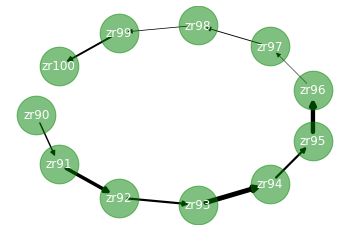

In [13]:
pos = nx.shell_layout(G, scale=1)  

widths = {e: G.edges[e]['weight']/10 for e in G.edges}

nx.draw_networkx_nodes(G,pos,
                       node_size=1500,
                       node_color='green',
                       alpha=0.5)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=1)
nx.draw_networkx_labels(G, pos=pos,
                        font_color='white')


plt.box(False)
plt.show()